# Find the best cross-validation run

In [131]:
import pandas as pd

df = pd.read_csv('data/fold_results.csv')

# Filter rows where 'Fold' is 'Average' and 'Final Model' is not 1
average_rows = df[(df['Fold'] == 'Average') & (df['Final Model'] != 1)]

best_f1_row = average_rows.loc[average_rows['F1'].idxmax()]
best_run_id = best_f1_row['Run ID']
print(best_f1_row)

print(best_run_id)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Fold                             Average
Run ID           20240630085259_1007361e
Final Model                            0
Best Loss                       0.477272
Loss                            0.477272
Accuracy                        0.874074
F1                               0.88171
Num Classes                            9
Input Size                            12
Hidden Size                          100
Num Layers                             2
Output Size                            1
Num Epochs                           600
Learning Rate                   0.000179
Batch Size                            32
Name: 10, dtype: object
20240630085259_1007361e


In [132]:
def get_hyperparameters_for_average_run(df, run_id):
    run_data = df[df['Run ID'] == run_id]

    if not run_data.empty:
        first_row = run_data.iloc[0]
        # Extract the hyperparameters
        hyperparameters = (
            first_row['Num Classes'],
            first_row['Input Size'],
            first_row['Hidden Size'],
            first_row['Num Layers'],
            first_row['Output Size'],
            first_row['Num Epochs'],
            first_row['Learning Rate'],
            first_row['Batch Size']
        )
        return hyperparameters
    else:
        return "Run ID not found."

In [134]:
ideal_hyperparameters = get_hyperparameters_for_average_run(df, best_run_id)
print(ideal_hyperparameters)

(9, 12, 100, 2, 1, 600, 0.000179, 32)


In [135]:
def find_runs_with_hyperparameters(df, hyperparameters):
    num_classes, input_size, hidden_size, num_layers, output_size, num_epochs, learning_rate, batch_size = hyperparameters
    
    # Filter the DataFrame for rows matching all specified hyperparameters
    matching_runs = df[
        (df['Num Classes'] == num_classes) &
        (df['Input Size'] == input_size) &
        (df['Hidden Size'] == hidden_size) &
        (df['Num Layers'] == num_layers) &
        (df['Output Size'] == output_size) &
        (df['Num Epochs'] == num_epochs) &
        (df['Learning Rate'] == learning_rate) &
        (df['Batch Size'] == batch_size)
    ]
    
    # Extract the 'Run ID' column from the filtered DataFrame and remove duplicates
    run_ids = tuple(matching_runs['Run ID'].unique())
    
    return run_ids


hyperparameters = (9, 12, 100, 2, 1, 600, 0.000179, 32)  # Replace this with the hyperparameters you're interested in
matching_run_ids = find_runs_with_hyperparameters(df, hyperparameters)
print(matching_run_ids)

('20240630085259_1007361e', '20240630095903_eec6aa6e', '20240630100950_132f9e5f')


# Loss Graphing

## Fold Average Losses

In [164]:
sns.set_theme(style="whitegrid", palette="pastel")

The maximum Row Index value is: 599
The maximum Row Index value is: 599


/tmp/ipykernel_2282466/2648274802.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Row Index'] = df_filtered.groupby('Fold Index').cumcount()
/tmp/ipykernel_2282466/2648274802.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Row Index'] = df_filtered.groupby('Fold Index').cumcount()
/tmp/ipykernel_2282466/2648274802.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

<Axes: xlabel='Row Index', ylabel='Mean Loss'>

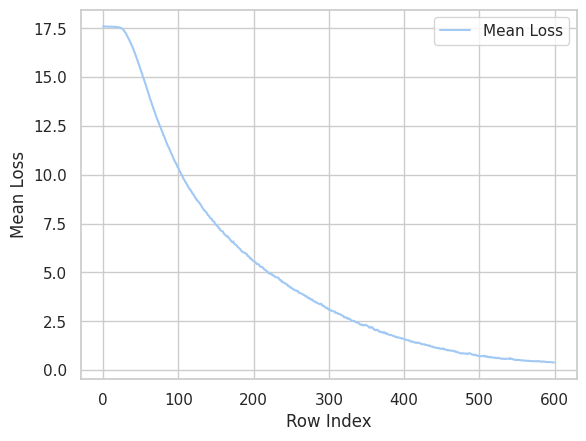

In [165]:


def get_mean_loss_stats_for_folds(run_ids):
    df = pd.read_csv("data/fold_detailed_losses.csv")
    aggregated_stats = pd.DataFrame()

    for run_id in run_ids:
        # Filter for entries with the correct 'Run ID' and not final models (Fold Index != 100)
        df_filtered = df[(df['Run ID'] == run_id) & (df['Fold Index'] != 100)]
        
        # If there are no entries after filtering, skip to the next iteration
        if df_filtered.empty:
            continue
        
        # Use groupby on 'Fold Index' and use cumcount to generate a new 'Row Index' that restarts for each fold
        df_filtered['Row Index'] = df_filtered.groupby('Fold Index').cumcount()

    # Reset index for the aggregated DataFrame
    df_filtered.reset_index(drop=True, inplace=True)
    
    return df_filtered

def calculate_mean_loss_by_index(df):
    mean_loss_by_index = df.groupby('Row Index')['Loss'].mean().reset_index()
    mean_loss_by_index.columns = ['Row Index', 'Mean Loss']
    
    return mean_loss_by_index

data = get_mean_loss_stats_for_folds(matching_run_ids)
max_row_index = data['Row Index'].max()
print(f"The maximum Row Index value is: {max_row_index}")

#print(data.head)
mean_loss_stuff = calculate_mean_loss_by_index(data)
max_row_index = mean_loss_stuff['Row Index'].max()
print(f"The maximum Row Index value is: {max_row_index}")

#print(mean_loss_stuff.head)
sns.lineplot(x='Row Index', y='Mean Loss', data=mean_loss_stuff, label='Mean Loss')

## Final-Model Average Loss

   Row Index  Mean Loss
0          0  10.994567
1          1  10.981514
2          2  10.983178
3          3  11.000769
4          4  10.992169
5          5  10.996350
6          6  10.999202
7          7  10.994676
8          8  10.972720
9          9  10.990191


/tmp/ipykernel_2282466/3270355921.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Row Index'] = range(len(df_filtered))


<Axes: xlabel='Row Index', ylabel='Mean Loss'>

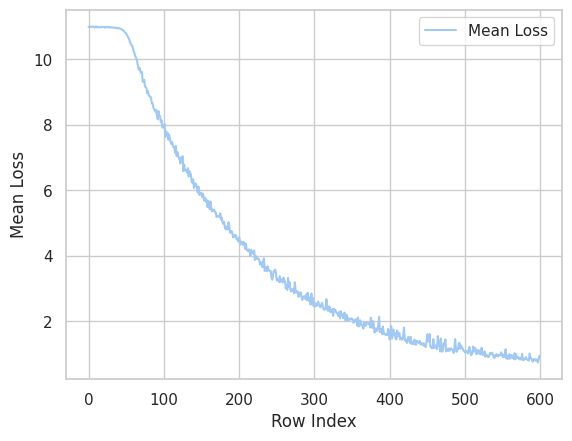

In [166]:
def extract_final_model_loss_by_run_id(run_ids):
    # Step 1: Load the CSV file into a DataFrame
    df = pd.read_csv("data/fold_detailed_losses.csv")
    
    # Initialize an empty DataFrame to store aggregated stats for all specified Run IDs
    aggregated_stats = pd.DataFrame()
    
    for run_id in run_ids:
        # Filter for only entries with the correct 'Run ID' and is a final model (Fold Index == 100)
        df_filtered = df[(df['Run ID'] == run_id) & (df['Fold Index'] == 100)]
        
        # Check if there are any entries after filtering
        if not df_filtered.empty:
            # Instead of resetting the index, create a new column for the local row index
            # This will start counting from 0 for each Run ID
            df_filtered['Row Index'] = range(len(df_filtered))
            
            # Select the necessary columns, now including the new 'Row Index'
            df_final = df_filtered[['Row Index', 'Run ID', 'Loss']]
            
            # Append the results for this Run ID to the aggregated DataFrame
            aggregated_stats = pd.concat([aggregated_stats, df_final], ignore_index=True)
    
    return aggregated_stats


final_model_loss_data_across = extract_final_model_loss_by_run_id(['20240630123146_7cd6de13'])
mean_losses = calculate_mean_loss_by_index(final_model_loss_data_across)
print(mean_losses.head(10))
sns.lineplot(x='Row Index', y='Mean Loss', data=mean_losses, label='Mean Loss')

# Metrics Graphing

## Fold Metrics

  Fold                   Run ID  Accuracy        F1
0    0  20240630085259_1007361e  0.888889  0.889851
1    1  20240630085259_1007361e  1.000000  1.000000
2    2  20240630085259_1007361e  0.740741  0.752028
3    3  20240630085259_1007361e  0.888889  0.913131
4    4  20240630085259_1007361e  0.925926  0.922399


<Axes: xlabel='Run ID', ylabel='Accuracy'>

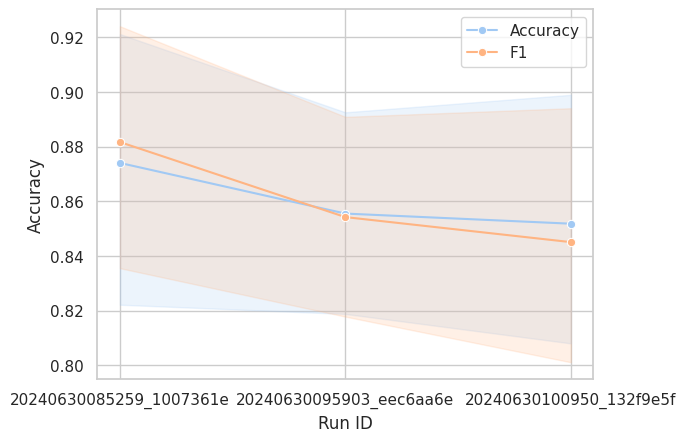

In [167]:
def get_folds_model(run_ids):
    df = pd.read_csv("data/fold_results.csv")  
    df_folds = df[df['Final Model'] != 1]
    df_filtered = df_folds[df_folds['Run ID'].isin(run_ids)]
    accuracy_data = df_filtered[['Fold', 'Run ID', 'Accuracy', 'F1']]
    
    return accuracy_data


# Example usage
accuracy_data = get_folds_model(matching_run_ids)
print(accuracy_data.head(5))
sns.lineplot(x='Run ID', y='Accuracy', data=accuracy_data, marker='o', label='Accuracy')
sns.lineplot(x='Run ID', y='F1', data=accuracy_data, marker='o', label='F1')

## Final Model Metrics

   Fold                   Run ID  Accuracy        F1
11    0  20240630085259_1007361e  0.843243  0.843829
71    0  20240630095903_eec6aa6e  0.883784  0.884774
83    0  20240630100950_132f9e5f  0.878378  0.879679
84    0  20240630100950_132f9e5f  0.864865  0.866411


<Axes: xlabel='Run ID', ylabel='Accuracy'>

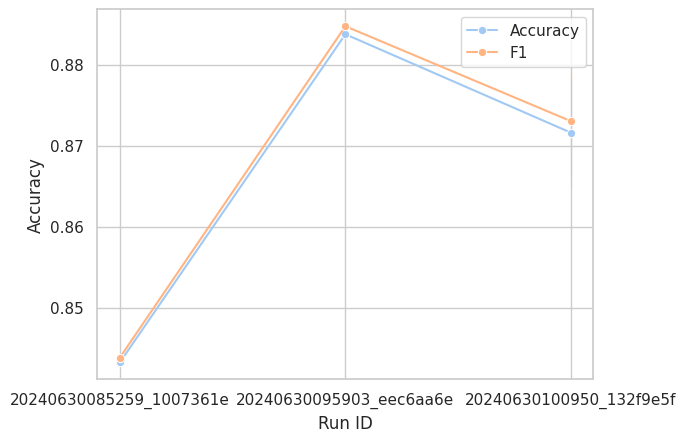

In [168]:
def get_metrics_final_model(run_ids):
    df = pd.read_csv("data/fold_results.csv")  
    df_final_models = df[df['Final Model'] == 1]
    df_filtered = df_final_models[df_final_models['Run ID'].isin(run_ids)]
    accuracy_data = df_filtered[['Fold', 'Run ID', 'Accuracy', 'F1']]
    
    return accuracy_data


# Example usage
accuracy_data = get_metrics_final_model(matching_run_ids)
print(accuracy_data.head(5))
sns.lineplot(x='Run ID', y='Accuracy', data=accuracy_data, marker='o', label='Accuracy')
sns.lineplot(x='Run ID', y='F1', data=accuracy_data, marker='o', label='F1')

# Hyperparameter Comparisons

In [169]:
# DO HYPER-PARAMETER COMPARISON

def metrics_vs_learning_rate():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_lr = df_average[['Learning Rate', 'F1', 'Accuracy']]
    
    return df_lr

def metrics_vs_hidden_size():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_hs = df_average[['Hidden Size', 'F1', 'Accuracy']]
    
    return df_hs

def metrics_vs_epochs():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_ep = df_average[['Num Epochs', 'F1', 'Accuracy']]
    
    return df_ep

def metrics_vs_batch_size():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_bs = df_average[['Batch Size', 'F1', 'Accuracy']]
    
    return df_bs

## Learning Rate per Folds

    Learning Rate        F1  Accuracy
10       0.000179  0.881710  0.874074
22       0.000058  0.661093  0.670370
34       0.000200  0.839489  0.837037
46       0.000170  0.823380  0.829630
58       0.000165  0.842551  0.840741


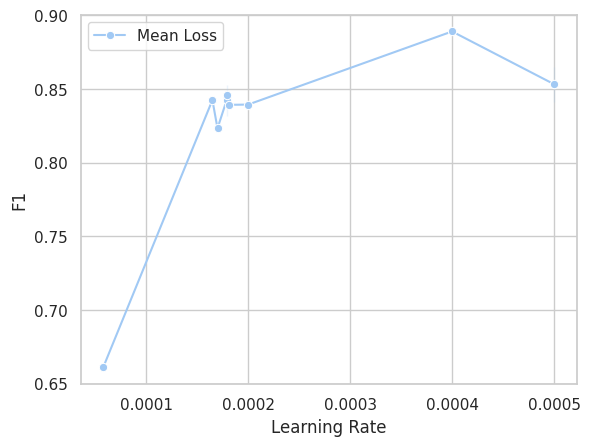

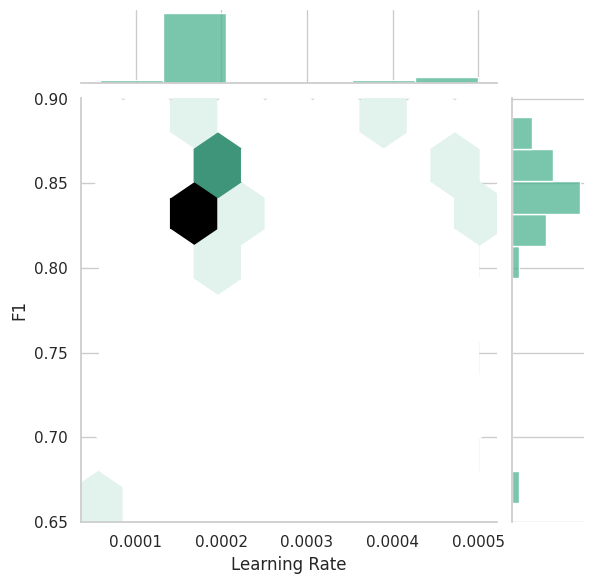

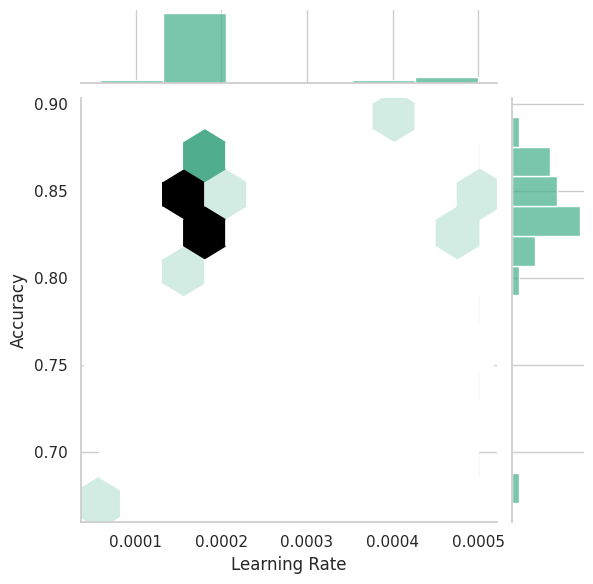

In [170]:
f1_tuning = metrics_vs_learning_rate()

print(f1_tuning.head(5))
sns.lineplot(x='Learning Rate', y='F1', data=f1_tuning, marker='o', label='Mean Loss')

sns.jointplot(x='Learning Rate', y='F1', data=f1_tuning, kind="hex", color="#4CB391")
sns.jointplot(x='Learning Rate', y='Accuracy', data=f1_tuning, kind="hex", color="#4CB391")

## Hidden Size per Folds

    Hidden Size        F1  Accuracy
10          100  0.881710  0.874074
22          100  0.661093  0.670370
34          100  0.839489  0.837037
46          100  0.823380  0.829630
58          100  0.842551  0.840741


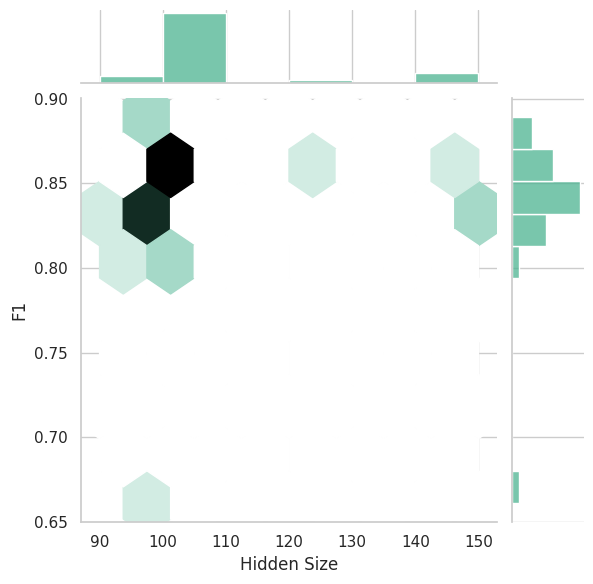

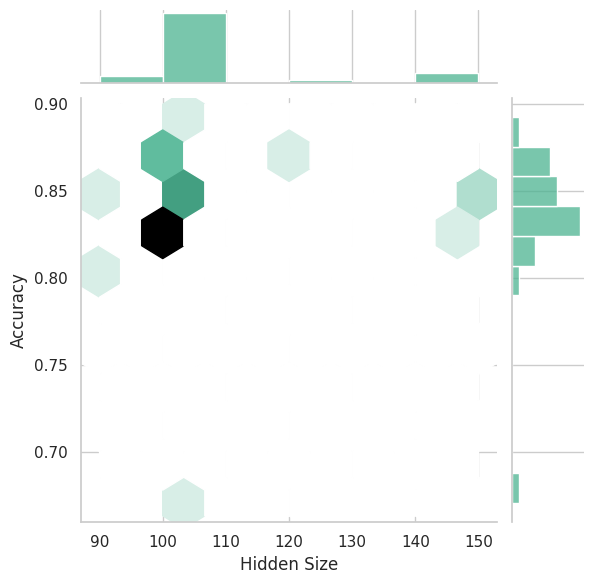

In [171]:
hidden_size_data = metrics_vs_hidden_size()
print(hidden_size_data.head(5))
sns.jointplot(x='Hidden Size', y='F1', data=hidden_size_data, kind="hex", color="#4CB391")
sns.jointplot(x='Hidden Size', y='Accuracy', data=hidden_size_data, kind="hex", color="#4CB391")

## Epochs per Folds

    Hidden Size        F1  Accuracy
10          100  0.881710  0.874074
22          100  0.661093  0.670370
34          100  0.839489  0.837037
46          100  0.823380  0.829630
58          100  0.842551  0.840741


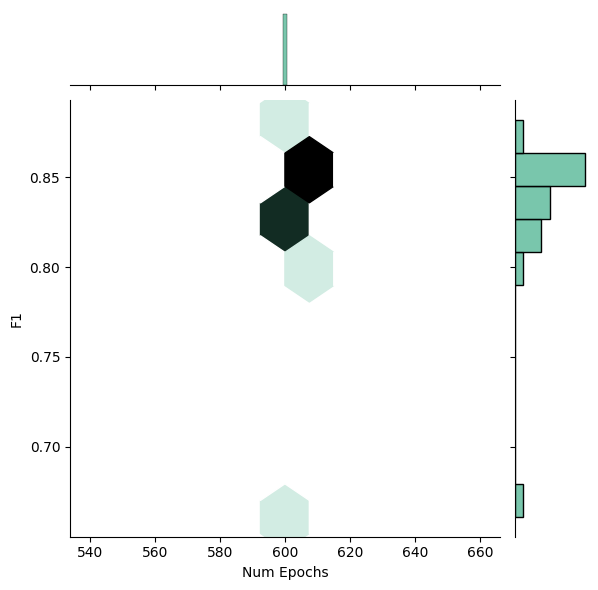

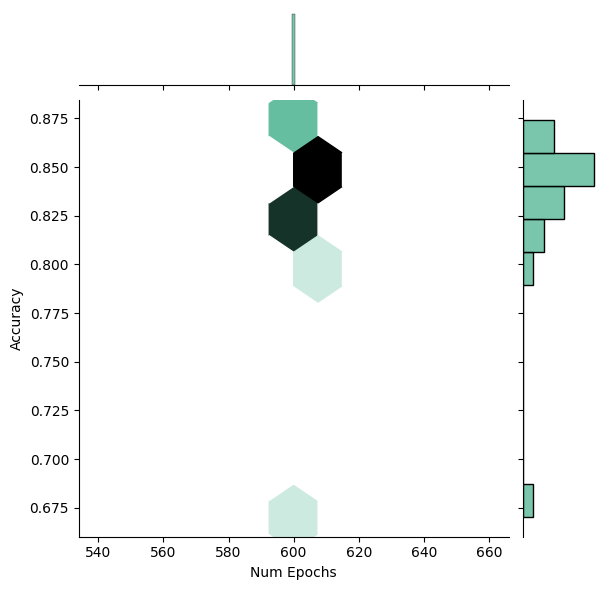

In [106]:
epoch_data = metrics_vs_epochs()
print(hidden_size_data.head(5))
sns.jointplot(x='Num Epochs', y='F1', data=epoch_data, kind="hex", color="#4CB391")
sns.jointplot(x='Num Epochs', y='Accuracy', data=epoch_data, kind="hex", color="#4CB391")

## Batch Size per Folds

    Batch Size        F1  Accuracy
10          32  0.881710  0.874074
22          32  0.661093  0.670370
34          32  0.839489  0.837037
46          32  0.823380  0.829630
58          32  0.842551  0.840741


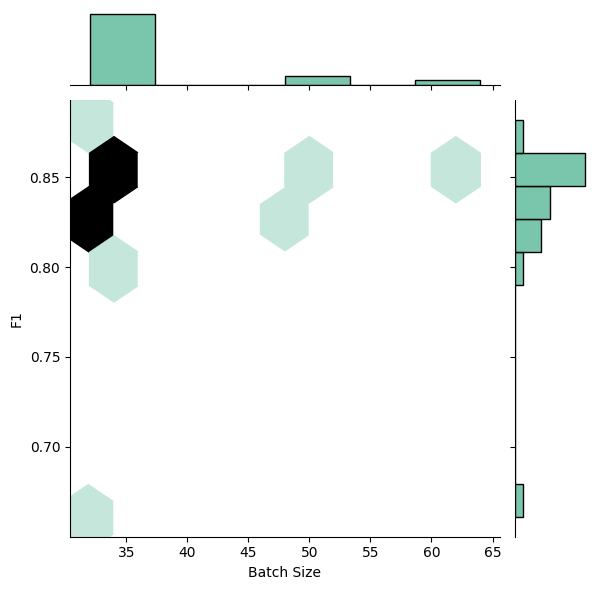

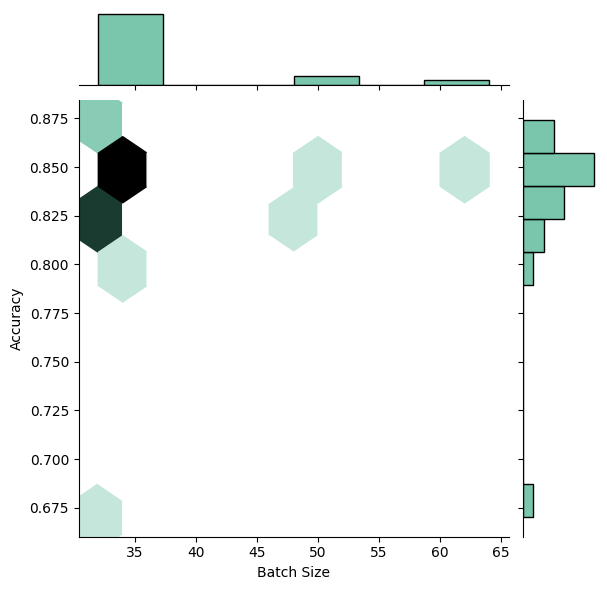

In [107]:
batch_data = metrics_vs_batch_size()
print(batch_data.head(5))
sns.jointplot(x='Batch Size', y='F1', data=batch_data, kind="hex", color="#4CB391")
sns.jointplot(x='Batch Size', y='Accuracy', data=batch_data, kind="hex", color="#4CB391")